In [13]:
import pandas as pd
import numpy as np
import talib as ta
import pyfolio as pf
import backtrader as bt
import datetime
from copy import deepcopy

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker  # 导入设置坐标轴的模块
%matplotlib inline

In [2]:
data = pd.read_csv("./Data/sample_test.csv")
data = data.set_index(pd.to_datetime(data['Gmt time'],dayfirst=True))
data = data.drop('Gmt time',axis = 1)

In [3]:
data

,Open,High,Low,Close,Volume
Gmt time,,,,,
2008-01-01 00:00:00,1.45841,1.45850,1.45770,1.45792,2624.75
2008-01-01 00:05:00,1.45792,1.45948,1.45787,1.45928,589.10
2008-01-01 00:10:00,1.45952,1.45975,1.45948,1.45961,704.50
2008-01-01 00:15:00,1.45965,1.45982,1.45933,1.45946,954.00
2008-01-01 00:20:00,1.45958,1.45981,1.45938,1.45950,610.30
...,...,...,...,...,...
2008-02-29 23:35:00,1.51762,1.51762,1.51762,1.51762,0.00
2008-02-29 23:40:00,1.51762,1.51762,1.51762,1.51762,0.00
2008-02-29 23:45:00,1.51762,1.51762,1.51762,1.51762,0.00


In [4]:
class TestStrategy(bt.Strategy):
    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.datetime(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.5f' % self.dataclose[0])


In [5]:
cerebro3 = bt.Cerebro(stdstats=False)
cerebro3.broker.set_cash(100000)
datafeed1 = bt.feeds.PandasData(dataname=data)
cerebro3.adddata(datafeed1, name='EURUSD')
cerebro3.addstrategy(TestStrategy)
result = cerebro3.run()

2008-01-01T00:00:00, Close, 1.45792
2008-01-01T00:05:00, Close, 1.45928
2008-01-01T00:10:00, Close, 1.45961
2008-01-01T00:15:00, Close, 1.45946
2008-01-01T00:20:00, Close, 1.45950
2008-01-01T00:25:00, Close, 1.45937
2008-01-01T00:30:00, Close, 1.45952
2008-01-01T00:35:00, Close, 1.45959
2008-01-01T00:40:00, Close, 1.45865
2008-01-01T00:45:00, Close, 1.45858
2008-01-01T00:50:00, Close, 1.45783
2008-01-01T00:55:00, Close, 1.45785
2008-01-01T01:00:00, Close, 1.45793
2008-01-01T01:05:00, Close, 1.45776
2008-01-01T01:10:00, Close, 1.45780
2008-01-01T01:15:00, Close, 1.45781
2008-01-01T01:20:00, Close, 1.45777
2008-01-01T01:25:00, Close, 1.45784
2008-01-01T01:30:00, Close, 1.45768
2008-01-01T01:35:00, Close, 1.45776
2008-01-01T01:40:00, Close, 1.45785
2008-01-01T01:45:00, Close, 1.45789
2008-01-01T01:50:00, Close, 1.45761
2008-01-01T01:55:00, Close, 1.45770
2008-01-01T02:00:00, Close, 1.45820
2008-01-01T02:05:00, Close, 1.45970
2008-01-01T02:10:00, Close, 1.45960
2008-01-01T02:15:00, Close, 

回测图表自定义修改

In [6]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = 15, 10

class my_Trades(bt.observers.Trades):
    # 替换为三角标记
    plotlines = dict(
    pnlplus=dict(_name='Positive',
                 marker='^', color='#ed665d',
                 markersize=8.0, fillstyle='full'),
    pnlminus=dict(_name='Negative',
                  marker='v', color='#729ece',
                  markersize=8.0, fillstyle='full'))


class my_BuySell(bt.observers.BuySell):
    # 替换为箭头标记
    params = (('barplot', True), ('bardist', 0.02))
    
    plotlines = dict(
    buy=dict(marker=r'$\Uparrow$', markersize=10.0, color='#d62728' ),
    sell=dict(marker=r'$\Downarrow$', markersize=10.0, color='#2ca02c'))
    


In [7]:
class TestStrategy(bt.Strategy):
    params = (
        ('period1', 5),
        ('period2', 20),
    )

    def __init__(self):
        sma1 = bt.indicators.SMA(period=self.p.period1)  # 短期均线
        sma2 = bt.indicators.SMA(period=self.p.period2)  # 长期均线
        # 短期均线上穿长期均线，取值为 1；短期均线下穿长期均线，取值为 -1；相等，取值为 0
        self.crossover = bt.indicators.CrossOver(sma1, sma2, plot=True)  
        self.order = None
        
    def next(self):
        # 下穿卖出
        if self.position:
            if self.crossover < 0.0: 
                self.order = self.close()
                print('CLOSE {} close {}'.format(self.position.size, self.data.close[0]))
        # 上穿买入
        else:
            if self.crossover > 0.0:
                self.order = self.buy(size=500)
                print('BUY {} close {}'.format(500, self.data.close[0]))



In [9]:
st_date = datetime.datetime(2008,1,1)
ed_date = datetime.datetime(2008,8,1)

In [10]:
cerebro1 = bt.Cerebro(stdstats=False)
cerebro1.broker.set_cash(10000)
datafeed = bt.feeds.PandasData(dataname=data, 
                                fromdate=st_date, 
                                todate=ed_date)
cerebro1.adddata(datafeed, name='EURUSD')

cerebro1.addstrategy(TestStrategy)
cerebro1.addobserver(bt.observers.DrawDown)
cerebro1.addobserver(bt.observers.Benchmark, data=datafeed1)
cerebro1.addobserver(bt.observers.Broker)
cerebro1.addobserver(my_Trades)
cerebro1.addobserver(my_BuySell)
cerebro1.addanalyzer(bt.analyzers.TimeReturn, _name='_TimeReturn')
result = cerebro1.run()


BUY 500 close 1.4597
CLOSE 500 close 1.45906
BUY 500 close 1.45982
CLOSE 500 close 1.45928
BUY 500 close 1.46001
CLOSE 500 close 1.45908
BUY 500 close 1.45887
CLOSE 500 close 1.45862
BUY 500 close 1.45896
CLOSE 500 close 1.45885
BUY 500 close 1.4588
CLOSE 500 close 1.45857
BUY 500 close 1.45903
CLOSE 500 close 1.45862
BUY 500 close 1.45873
CLOSE 500 close 1.45856
BUY 500 close 1.45907
CLOSE 500 close 1.45836
BUY 500 close 1.45877
CLOSE 500 close 1.45852
BUY 500 close 1.45894
CLOSE 500 close 1.45857
BUY 500 close 1.45904
CLOSE 500 close 1.45862
BUY 500 close 1.45885
CLOSE 500 close 1.45877
BUY 500 close 1.45956
CLOSE 500 close 1.45935
BUY 500 close 1.45836
CLOSE 500 close 1.45882
BUY 500 close 1.45915
CLOSE 500 close 1.46079
BUY 500 close 1.4603
CLOSE 500 close 1.46143
BUY 500 close 1.46213
CLOSE 500 close 1.46496
BUY 500 close 1.46663
CLOSE 500 close 1.46528
BUY 500 close 1.46617
CLOSE 500 close 1.46845
BUY 500 close 1.46934
CLOSE 500 close 1.46727
BUY 500 close 1.46899
CLOSE 500 close

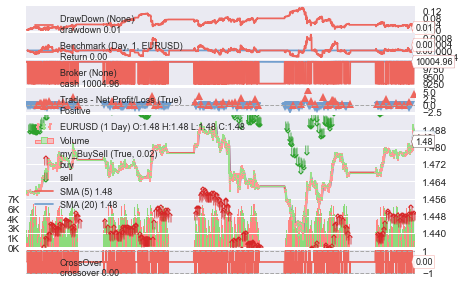

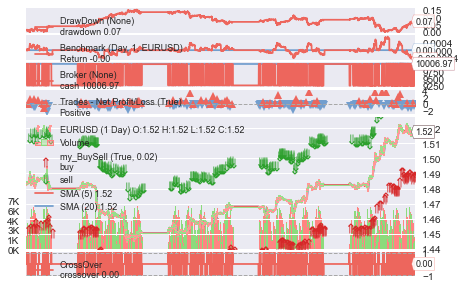

[[<Figure size 432x288 with 7 Axes>, <Figure size 432x288 with 7 Axes>]]

In [14]:
%matplotlib inline

colors = ['#729ece', '#ff9e4a', '#67bf5c', '#ed665d', '#ad8bc9', '#a8786e', '#ed97ca', '#a2a2a2', '#cdcc5d', '#6dccda']
tab10_index = [3, 0, 2, 1, 2, 4, 5, 6, 7, 8, 9]
cerebro1.plot(iplot=False,  style='candel', 
              lcolors=colors , 
              plotdist=0.1, 
              bartrans=0.2, 
              barup = '#ff9896', bardown='#98df8a',
              volup='#ff9896', voldown='#98df8a',  numfigs=2,
              grid=False)

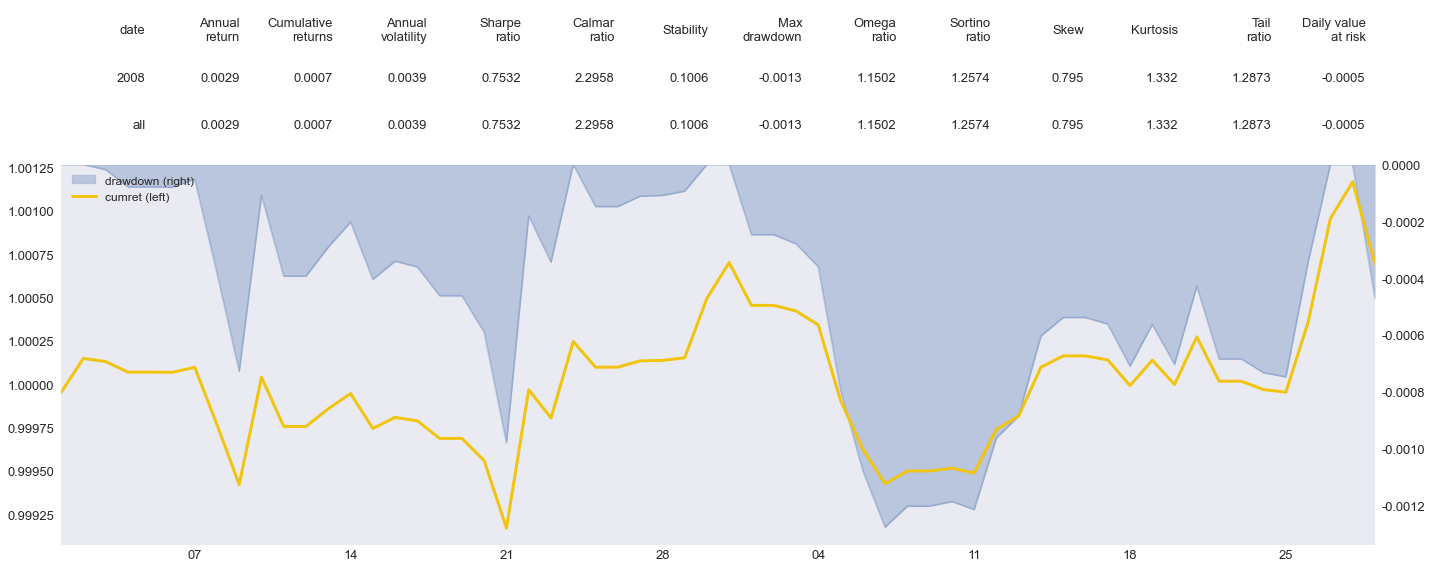

In [15]:
# 提取收益序列
pnl = pd.Series(result[0].analyzers._TimeReturn.get_analysis())
# 计算累计收益
cumulative = (pnl + 1).cumprod()
# 计算回撤序列
max_return = cumulative.cummax()
drawdown = (cumulative - max_return) / max_return
# 按年统计收益指标
perf_stats_year = (pnl).groupby(pnl.index.to_period('y')).apply(lambda data: pf.timeseries.perf_stats(data)).unstack()
# 统计所有时间段的收益指标
perf_stats_all = pf.timeseries.perf_stats((pnl)).to_frame(name='all')
perf_stats = pd.concat([perf_stats_year, perf_stats_all.T], axis=0)
perf_stats_ = round(perf_stats,4).reset_index()

# 绘制图形
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.style.use('seaborn')  # plt.style.use('dark_background')

fig, (ax0, ax1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[1.5, 4]}, figsize=(20,8))
cols_names = ['date', 'Annual\nreturn', 'Cumulative\nreturns', 'Annual\nvolatility',
       'Sharpe\nratio', 'Calmar\nratio', 'Stability', 'Max\ndrawdown',
       'Omega\nratio', 'Sortino\nratio', 'Skew', 'Kurtosis', 'Tail\nratio',
       'Daily value\nat risk']

# 绘制表格
ax0.set_axis_off()  # 除去坐标轴
table = ax0.table(cellText = perf_stats_.values, 
                bbox=(0,0,1,1),  # 设置表格位置， (x0, y0, width, height)
                rowLoc = 'right',  # 行标题居中
                cellLoc='right' ,
                colLabels = cols_names, # 设置列标题
                colLoc = 'right',  # 列标题居中
                edges = 'open' # 不显示表格边框
                )
table.set_fontsize(13)

# 绘制累计收益曲线
ax2 = ax1.twinx()
ax1.yaxis.set_ticks_position('right') # 将回撤曲线的 y 轴移至右侧
ax2.yaxis.set_ticks_position('left') # 将累计收益曲线的 y 轴移至左侧
# 绘制回撤曲线
drawdown.plot.area(ax=ax1, label='drawdown (right)', rot=0, alpha=0.3, fontsize=13, grid=False)
# 绘制累计收益曲线
(cumulative).plot(ax=ax2, color='#F1C40F' , lw=3.0, label='cumret (left)', rot=0, fontsize=13, grid=False)
# 不然 x 轴留有空白
ax2.set_xbound(lower=cumulative.index.min(), upper=cumulative.index.max())
# 主轴定位器：每 5 个月显示一个日期：根据具体天数来做排版
ax2.xaxis.set_major_locator(ticker.MultipleLocator(100)) 
# 同时绘制双轴的图例
h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2,l1+l2, fontsize=12, loc='upper left', ncol=1)

fig.tight_layout() # 规整排版
plt.show()